In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import scipy
import math
from scipy.stats import genextreme as gev, gumbel_r, norm, gompertz
from scipy.special import gamma, factorial
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

from constants import * 
from utils import *

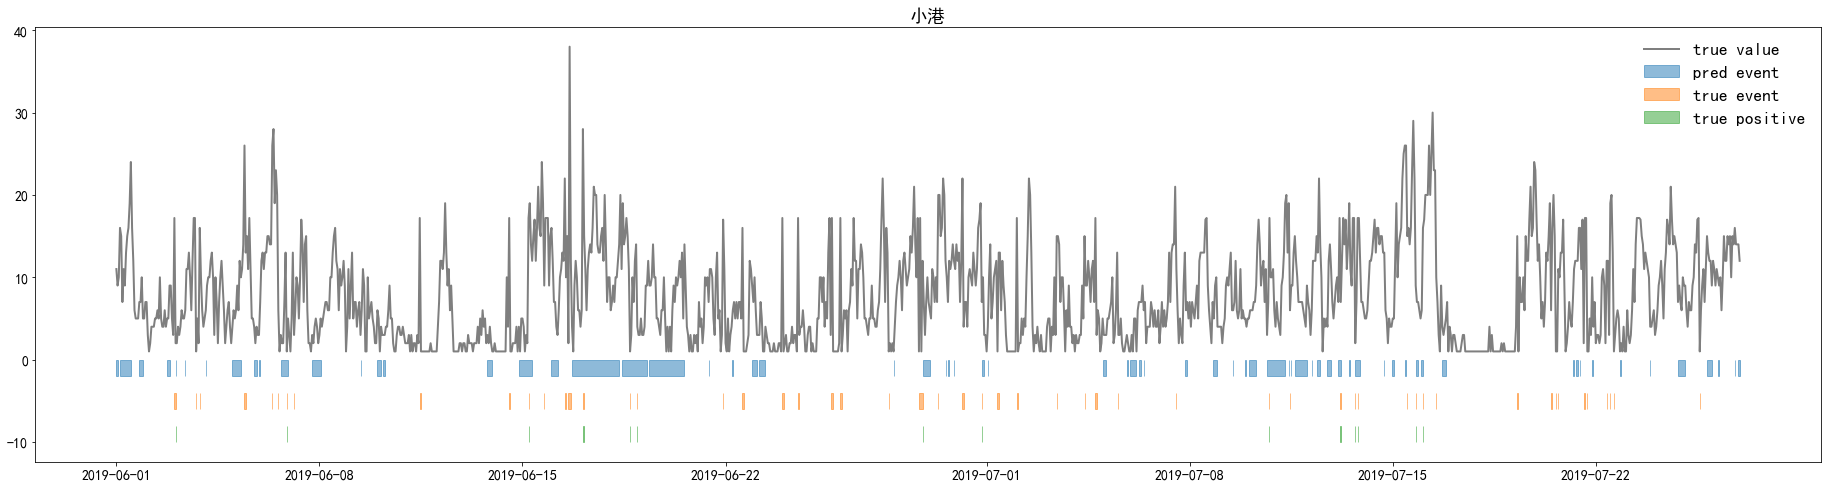

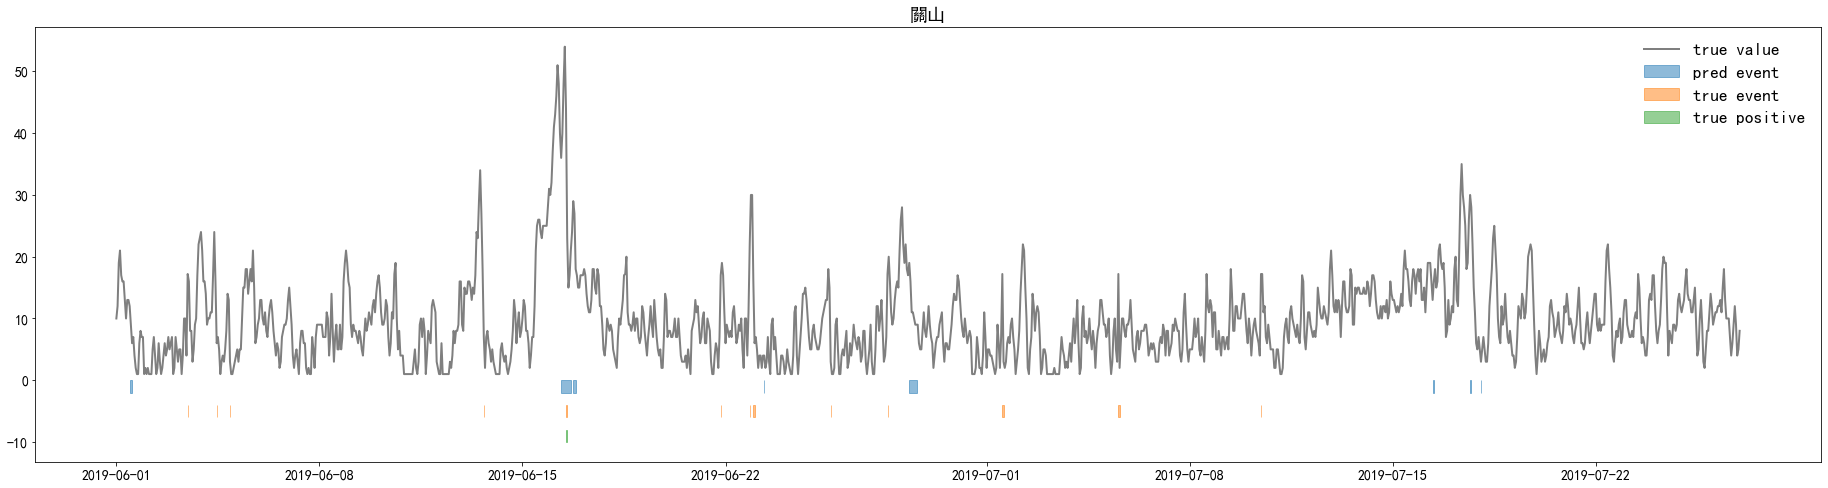

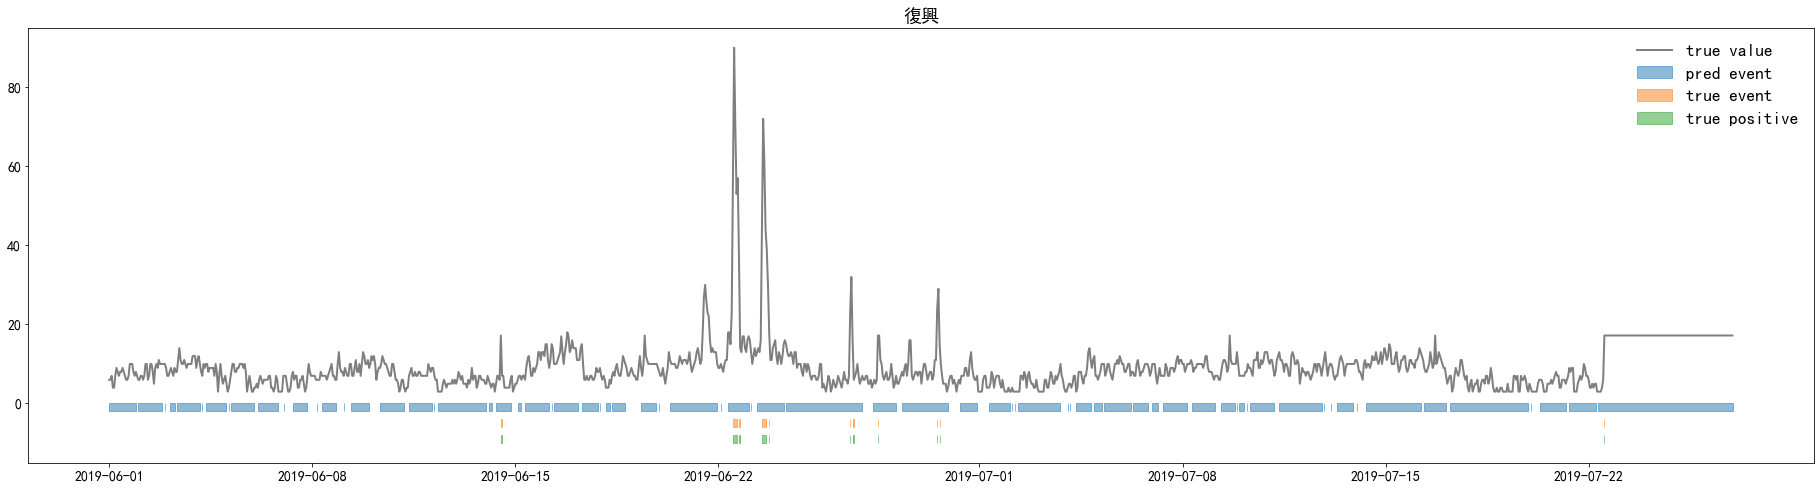

In [20]:
# For classification output
def plot(sitename, opt):
    no = opt.no
    # -------------------------------
    # Load data
    # -------------------------------
    pred   = np.load(f"{opt.rst_dir}/{no}/{sitename}.npy")[:,:,0]
#     if opt.model != "fudan":
    pred = pred[:, -1]
    true   = np.load(f"{opt.origin_valid_dir}/{sitename}.npy")
    thres  = np.load(f"{opt.thres_valid_dir}/{sitename}.npy") 
    date   = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    mask   = get_mask(opt, true, thres)
#     print("before: ", pred.shape, true.shape, thres.shape, date.shape, mask.shape)
    total_size = true.shape[0]
    # -------------------------------
    # Filter data
    # -------------------------------
    # Here we only consider PM2.5 feature
    true  = true [:, 7]
    thres = thres[:, 7]
    mask  = mask [:, 0]
    # -------------------------------
    # Shift data
    # -------------------------------
    ## shift [-1, -2, ...]
    # here only consider the last 1, that is, shift = -1
    shift = -1
    true  = true [:total_size+shift+1]
    thres = thres[:total_size+shift+1]
    date  = date [:total_size+shift+1]
    mask  = mask [:total_size+shift+1]
    
    true  = true [-pred.shape[0]:]
    thres = thres[-pred.shape[0]:]
    date  = date [-pred.shape[0]:]
    mask  = mask [-pred.shape[0]:]
#     print("after: ", pred.shape, true.shape, thres.shape, date.shape, mask.shape)
    # -------------------------------
    # Zoom data
    # -------------------------------
    st = np.where(date == '2019/06/01 00:00')[0][0]
    ed = st + 24 * 28 * 2
#     st = 0
#     ed = -1
    true  = true  [st:ed]
    thres = thres [st:ed]
    mask  = mask  [st:ed]
    x     = date  [st:ed]
    pred  = pred  [st:ed]
    acc   = pred == mask
    # -------------------------------
    # Draw data
    # -------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    pos = np.arange(100) * -2
    ax.fill_between(x, pos[1], pos[0], 
                    where=pred>.5, 
                    color='tab:blue', 
                    alpha=0.5, 
#                     transform=ax.get_xaxis_transform(),
                    label='pred event'
                   )
    ax.fill_between(x, pos[3], pos[2], 
                    where=mask>.5, 
                    color='tab:orange', 
                    alpha=0.5, 
#                     transform=ax.get_xaxis_transform(),
                    label='true event'
                   )
    ax.fill_between(x, pos[5], pos[4], 
                    where= np.logical_and(pred>.5, mask>.5),
                    color='tab:green', 
                    alpha=0.5, 
                    label='true positive'
                   )
#     ax.fill_between(x, -7, -6, 
#                     where= np.logical_and(pred>.5, mask<=.5),
#                     color='tab:red', 
#                     alpha=0.5, 
#                     label='false positive'
#                    )
#     ax.fill_between(x, -9, -8, 
#                     where= np.logical_and(pred<=.5, mask>.5),
#                     color='tab:purple', 
#                     alpha=0.5, 
#                     label='false negative'
#                    )
#     ax.fill_between(x, -11, -10, 
#                     where= np.logical_and(pred<=.5, mask<=.5),
#                     color='tab:brown', 
#                     alpha=0.5, 
#                     label='true negative'
#                    )
#     ax.fill_between(x, -7, -6,
#                 where=acc == 1, 
#                 color='y', 
#                 alpha=0.5, 
#                 label='accuracy'
#                )
    ax.plot(x, true,      color='black',  lw=2,  alpha=.5, label='true value')
    ax.legend(loc='upper right', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

no = 426
args = [f"--no={no}"]
opt = parse(args)
with open(f"{opt.cfg_dir}/{opt.no}.json", "r") as fp:
    opt = json.load(fp)
opt = Namespace(**opt)
# opt.use_abs_delta = False
same_seeds(opt.seed)
shift = -1 # -1 ... -target_size

# for sitename in SAMPLE_SITES:
# for sitename in ['左營', '復興', '頭份', '竹山', '林口', '嘉義', '恆春', '臺東', '忠明']:
# for sitename in ['陽明','豐原','左營','臺東']:
for sitename in ['小港', '關山', '復興']:
#     print(sitename)
    plot(sitename, opt)
#     break

陽明
max:  60.0 bins:  81
norm kl=4.265e-01 loc= 3.16 scale= 3.47
gev kl=2.304e-02 shape= -0.32 loc= 1.55 scale= 1.65


<ipython-input-126-920f5511af38>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-126-920f5511af38>:12: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


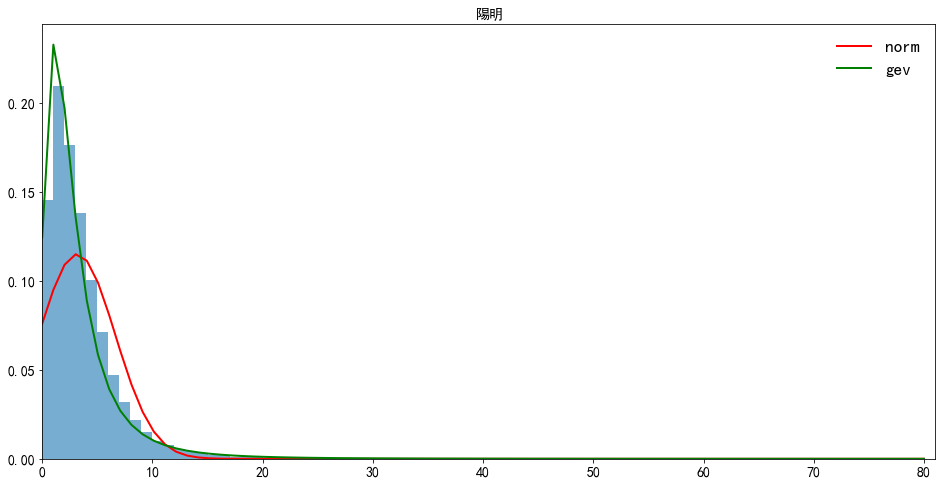

花蓮
max:  80.0 bins:  49
norm kl=3.350e-01 loc= 2.64 scale= 2.68
gev kl=3.114e-02 shape= -0.28 loc= 1.33 scale= 1.44


<ipython-input-126-920f5511af38>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-126-920f5511af38>:12: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


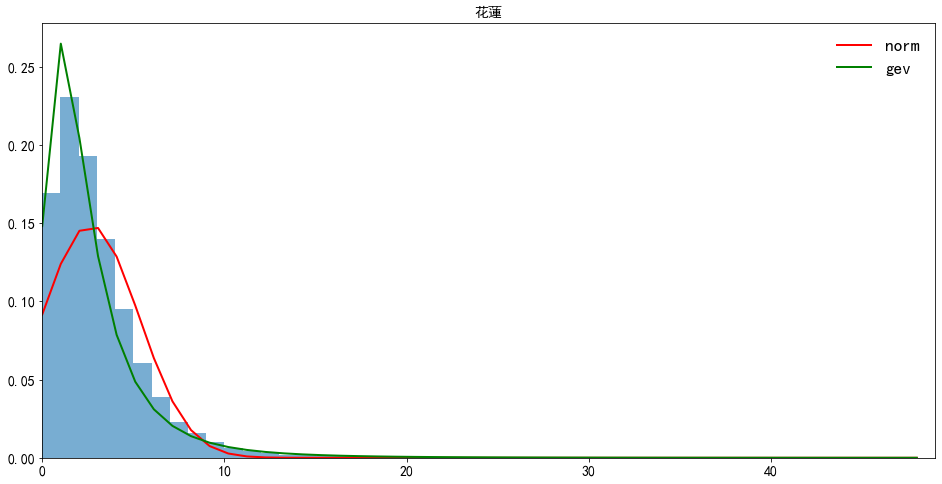

安南
max:  48.0 bins:  127


<ipython-input-126-920f5511af38>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-126-920f5511af38>:12: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


norm kl=4.042e-01 loc= 3.95 scale= 4.28
gev kl=3.838e-02 shape= -0.4 loc= 1.77 scale= 2.02


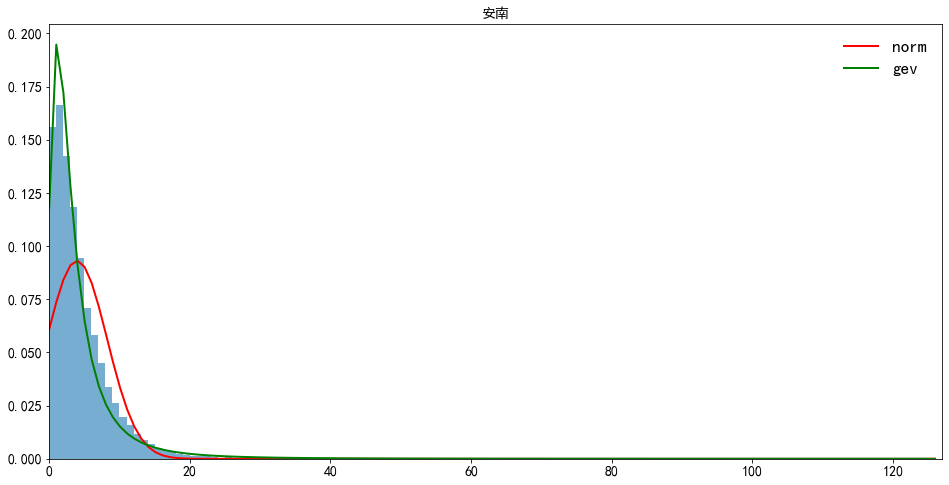

復興
max:  126.0 bins:  48
norm kl=3.895e-01 loc= 1.55 scale= 1.82
gev kl=1.407e-02 shape= -0.34 loc= 0.69 scale= 0.89


<ipython-input-126-920f5511af38>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-126-920f5511af38>:12: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


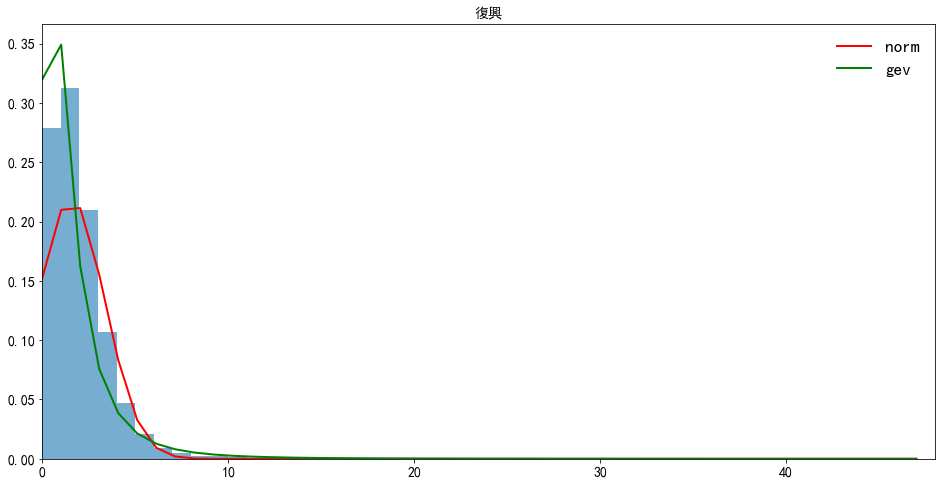

小港
max:  47.0 bins:  61
norm kl=5.772e-01 loc= 2.79 scale= 3.72
gev kl=-2.231e-04 shape= -0.83 loc= 0.77 scale= 1.15


<ipython-input-126-920f5511af38>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-126-920f5511af38>:12: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


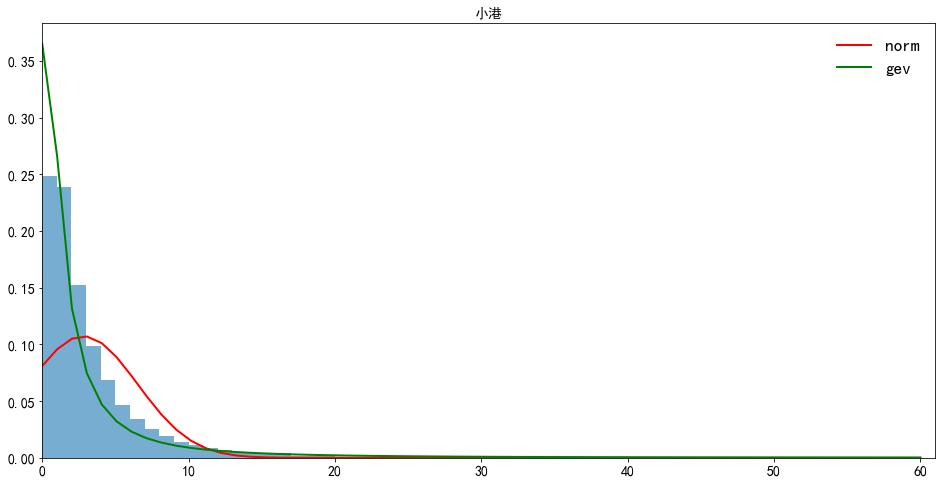

In [126]:
"""
    draw data distribution
"""

def gussion(x, position, width, height):
    return  height * math.sqrt(2*math.pi) * width * scipy.stats.norm.pdf(x, position, width)

def extreme(x, position, width, height, c=-0.1):
    return  height * math.sqrt(2*math.pi) * width * gev.pdf(x, c, position, width)

def kld(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

origin_all_path = opt.origin_all_dir

sitenames = ['陽明','花蓮','安南','復興','小港']

for idx, sitename in enumerate(sitenames):
    
    if opt.skip_site and sitename not in sample_sites:
        continue
    print(sitename)
    read_path = os.path.join(origin_all_path, f"{sitename}.npy")
#     data = np.load(read_path)[:, 7].astype(np.int)
    data = np.load(read_path)[:, 7]
    delta_data = abs(data[1:] - data[:-1])
    data = delta_data.astype(np.int)
    

#     data[data<0] = 0
    ratio = 1
    max_bin = int(np.max(data)) // ratio + 1
    print("max: ", np.max(x), "bins: ", max_bin) 
    
    bins = [i * ratio for i in range(max_bin)]
    hist, _ = np.histogram(data, bins=bins, density=True)
    
    # Prepare distribution
    x = np.linspace(0, max_bin-1, max_bin-1)
    
    gev_fit = gev.fit(data)
    gev_dist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_kl = kld(hist, gev_dist)
    
#     gumbel_r_fit = gumbel_r.fit(data)
#     gumbel_r_dist = gumbel_r.pdf(x, gumbel_r_fit[0], gumbel_r_fit[1])
#     gumbel_r_kl = kld(hist, gumbel_r_dist)
    
#     gompertz_fit = gompertz.fit(data)
#     gompertz_dist = gompertz.pdf(x, gompertz_fit[0], gompertz_fit[1], gompertz_fit[2])
#     gompertz_kl = kld(hist, gompertz_dist)
    
    norm_fit = norm.fit(data)
    norm_dist = norm.pdf(x, norm_fit[0], norm_fit[1])
    norm_kl = kld(hist, norm_dist)
    
    
    print(f'norm kl={norm_kl:.3e}'                                         ,'loc=',round(norm_fit[0],2), 'scale=',round(norm_fit[1],2))
#     print(f'gumbel_r kl={gumbel_r_kl:.3e}',                                    'loc=',round(gumbel_r_fit[0],2), 'scale=',round(gumbel_r_fit[1],2))
#     print(f'gompertz kl={gompertz_kl:.3e}', 'shape=',round(gompertz_fit[0],2), 'loc=',round(gompertz_fit[1],2), 'scale=',round(gompertz_fit[2],2))
    print(f'gev kl={gev_kl:.3e}',      'shape=',round(gev_fit[0],2),      'loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2))
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    ax.plot(x, norm_dist,    color='red', lw=2, alpha=1, label='norm')
#     ax.plot(x, gumbel_r_dist,    color='blue', lw=1, alpha=1, label='gumbel')
#     ax.plot(x, gompertz_dist,    color='purple', lw=1, alpha=1, label='gompertz')
    ax.plot(x, gev_dist,     color='green', lw=2, alpha=1, label='gev')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    plt.xlim(0, np.max(x)+1)
#     plt.ylim(0, .4)
    
    ax.hist(data, 
            np.max(data),
#             bins=bins,
            alpha=0.6,
            density=True
            )
    df.plot.density()
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    break
    

In [3]:
"""
    analyze the ratio of dataset
"""
no = 0
args = [
    "--threshold=54",
    "--delta=10", 
#     "--use_threshold",
#     "--use_min_threshold",
#     "--use_delta", 
#     "--use_abs_delta",

]
opt = parse(args)

results = []
for sitename in SITENAMES:
#     print(sitename)
    train_dataset = get_dataset(opt=opt, sitename=sitename, isTrain=True)
    valid_dataset = get_dataset(opt=opt, sitename=sitename, isTrain=False)
    
    train_ratio = train_dataset.get_ratio()
    valid_ratio = valid_dataset.get_ratio()
    
    results.append({
        'sitename': sitename,
        'train ratio'     : f"{1-train_ratio:.3%}",
        'valid ratio'     : f"{1-valid_ratio:.3%}",
        'threshold'       : f"{opt.threshold}",
        'delta'           : f"{opt.delta}",
        "use_threshold"   : f"{opt.use_threshold}",
        'use_min_theshold': f"{opt.use_min_threshold}",
        'use_delta'       : f"{opt.use_delta}",
        'use_abs_delta'   : f"{opt.use_abs_delta}",

    })
df = pd.DataFrame(results)
df.to_csv(f"data_ratio.csv", index=False, encoding='utf_8_sig')



In [21]:
class Test(nn.Module):
    def __init__(self,):
        super().__init__()
#         self.dense = nn.Linear(16, 32)
#         self.out = nn.Linear(32, 64)
#         self.dummy = nn.Linear(64, 8)
        self.rnn = nn.GRU(3, 2, batch_first=True)
        self.leru = nn.ReLU()
    def forward(self, x):
        return self.out(self.dense(x))
model = Test()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

42
